In [5]:
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.decomposition import PCA
import warnings

from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [21]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [22]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cuda


In [23]:
## Data Acquisition
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

In [24]:
def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

In [25]:
def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"
ratings = get_ratings_from_csv()
print(ratings)
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)
# films = get_data_from_csv(f"{root}/{ratings}")[]

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5
25000092  162541    56176     2.0
25000093  162541    58559     4.0
25000094  162541    63876     5.0

[25000095 rows x 3 columns]
Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 colum

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
from pytorch_tabnet.augmentations import RegressionSMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
           

class TabNet:
    def __init__(self, ratings, relevance, seed=42,width_values = 8, steps = 3, learning_rate = 2e-2):
        self.aug = RegressionSMOTE(p=0.2)
        #! df['rating'] = df['rating'].astype('float16')

        # Reduce genome-score size


        self.train_loss_history = []
        self.val_loss_history = []

        # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        #X = addColumnOperation(ratings,X)
        X.columns = X.columns.astype(str)
        ratings = None  
        train = X
        # mescolare le righe del DataFrame
        X = X.sample(frac=1,random_state = seed).reset_index(drop=True)
        
        if "Set" not in train.columns:
            train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

        features = [ col for col in train.columns if col not in ["rating", "Set"]]
        target = "rating"
        
        train_indices = train[train.Set=="train"].index
        valid_indices = train[train.Set=="valid"].index
        test_indices = train[train.Set=="test"].index

        self.X_train = train[features].values[train_indices]
        self.y_train = train[target].values[train_indices].reshape(-1, 1)

        self.X_valid = train[features].values[valid_indices]
        self.y_valid = train[target].values[valid_indices].reshape(-1, 1)

        self.X_test = train[features].values[test_indices]
        self.y_test = train[target].values[test_indices].reshape(-1, 1)

        pca = PCA()
        pca.fit(self.X_train)
        self.X_train = pca.transform(self.X_train)
        self.X_test = pca.transform(self.X_test)
        self.X_valid = pca.transform(self.X_valid)
        
        if torch.cuda.is_available():
            self.model = TabNetRegressor(n_d = width_values, 
                                         n_a = width_values , 
                                         n_steps = steps, 
                                         optimizer_params = 
                                         dict(lr=learning_rate), 
                                         seed=seed,  
                                         verbose=0, 
                                         device_name="cuda")  
        else:
            self.model = TabNetRegressor(n_d = width_values, n_a = width_values , n_steps = steps, optimizer_params = dict(lr=learning_rate), seed=seed, verbose=0)  



    def train(self,max_epochs = 150,batchsize = 1024):
        self.model.fit(
            X_train=self.X_train, y_train=self.y_train,
            eval_set=[(self.X_train,self.y_train), (self.X_valid, self.y_valid)],
            eval_name=['train', 'valid'],
            eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
            max_epochs=max_epochs,
            patience=20,
            batch_size=batchsize, virtual_batch_size=1024,
            num_workers=0,
            drop_last=False,
            augmentations=self.aug, #aug,
        ) 

        return self.model.history

    def test(self):
        # Predict the labels of the test set: y_pred
        y_pred = self.model.predict(self.X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        print("=====================================")
        return r2,self.model
    
    def load(self,model):
        self.model =TabNetRegressor()
        self.model.load_model(model)
    
    def save(self,root,name):
        self.model.save_model(f"{root}/{name}.pt")


In [27]:
model = TabNet(ratings, genome_scores)

In [28]:
import itertools

history = None

batchsize = [512,1024,2048]
width = [8,16,32]
steps = [3,5,7]
learning_rate = [2e-2,1e-2]
max_epochs = [70,120,150,210]

best_model_params = None 
best_r2 = 0

total_iterations = len(batchsize) * len(width) * len(steps) * len(learning_rate) * len(max_epochs)
current_iteration = 0

for batchsize,width,steps,learning_rate,max_epochs in itertools.product(batchsize,width,steps,learning_rate,max_epochs):
    current_iteration += 1
    print(f"[{current_iteration}/{total_iterations}] START => batchsize: {batchsize} width: {width} steps: {steps} learning_rate: {learning_rate} max_epochs: {max_epochs}")
    log_name = f'TabNet_{batchsize}_{width}_{steps}_{learning_rate}_{max_epochs}'


    writer = SummaryWriter('run/'+log_name)
    model = TabNet(ratings, genome_scores,width_values = width, steps = steps, learning_rate = learning_rate)
    history = model.train(max_epochs = max_epochs,batchsize = batchsize)
    r2score, instance = model.test()
    writer.add_hparams({'batchsize': batchsize, 'hidden_size1': width, 'hidden_size2': steps, 'lr': learning_rate, 'num_epochs': max_epochs}, {'metrics/r2': r2score})
    
    if r2score > best_r2:
        best_r2 = r2score
        best_model_params = f'{batchsize}_{width}_{steps}_{learning_rate}_{max_epochs}'
        model.save("model",best_model_params)
        print(f"New best model: {best_model_params} with r2: {best_r2}")

    writer.flush()
writer.close()
model = TabNet(ratings,genome_scores)
print(f'Best model SCORE: {best_r2}')
model.load(f"model/{best_model_params}.pt.zip")
print(model.test())



[1/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.05191


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05210912650785237 RMSE: 0.2282742353132573 R2: 0.7693329755640941 MAE: 0.17691617550273947
Successfully saved model at model/512_8_3_0.02_70.pt.zip
New best model: 512_8_3_0.02_70 with r2: 0.7693329755640941
[2/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.02282


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02384098172684262 RMSE: 0.15440525161678478 R2: 0.8944651602683669 MAE: 0.11771430175260135
Successfully saved model at model/512_8_3_0.02_120.pt.zip
New best model: 512_8_3_0.02_120 with r2: 0.8944651602683669
[3/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 142 and best_valid_mse = 0.01425


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.015865488916844934 RMSE: 0.12595828244639148 R2: 0.9297695938327043 MAE: 0.09470088260495114
Successfully saved model at model/512_8_3_0.02_150.pt.zip
New best model: 512_8_3_0.02_150 with r2: 0.9297695938327043
[4/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 199 and best_valid_mse = 0.0112


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012942815630610546 RMSE: 0.11376649608127407 R2: 0.9427071423105589 MAE: 0.08609831465050595
Successfully saved model at model/512_8_3_0.02_210.pt.zip
New best model: 512_8_3_0.02_210 with r2: 0.9427071423105589
[5/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.07394


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07854032854505065 RMSE: 0.28025047465624503 R2: 0.6523322285785147 MAE: 0.22052411475059883
[6/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.03801


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03875474164334836 RMSE: 0.196862240268032 R2: 0.828447691666711 MAE: 0.15017869878228784
[7/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_mse = 0.02183


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022916702590764233 RMSE: 0.15138263635821722 R2: 0.8985565878618665 MAE: 0.10926680744976741
[8/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 205 and best_valid_mse = 0.01412


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01380257811330343 RMSE: 0.1174843739111863 R2: 0.938901305082132 MAE: 0.08338525869056392
[9/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 70

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.09252


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09989644712509797 RMSE: 0.31606399213624126 R2: 0.5577969205338182 MAE: 0.24058353504254723
[10/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.09252


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09989644712509797 RMSE: 0.31606399213624126 R2: 0.5577969205338182 MAE: 0.24058353504254723
[11/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.09252


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09989644712509797 RMSE: 0.31606399213624126 R2: 0.5577969205338182 MAE: 0.24058353504254723
[12/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.09252


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09989644712509797 RMSE: 0.31606399213624126 R2: 0.5577969205338182 MAE: 0.24058353504254723
[13/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.16164


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1664952632366941 RMSE: 0.40803831099137505 R2: 0.26298962336868503 MAE: 0.32375105058541354
[14/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.02375


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.023125964946856405 RMSE: 0.15207223595007868 R2: 0.8976302640441193 MAE: 0.11689933836019716
[15/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 145 and best_valid_mse = 0.0158


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016600589654245802 RMSE: 0.12884327554919506 R2: 0.9265155861161991 MAE: 0.0986151309788559
[16/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 203 and best_valid_mse = 0.00851


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009798249498806961 RMSE: 0.09898610760509255 R2: 0.9566269249163133 MAE: 0.07300380915554663
Successfully saved model at model/512_8_5_0.01_210.pt.zip
New best model: 512_8_5_0.01_210 with r2: 0.9566269249163133
[17/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.02832


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.035824932902846975 RMSE: 0.189274755059535 R2: 0.8414168260511824 MAE: 0.14122447899747048
[18/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 107 and best_valid_mse = 0.00834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009675581572380524 RMSE: 0.09836453411865745 R2: 0.9571699285603725 MAE: 0.07256054381110555
Successfully saved model at model/512_8_7_0.02_120.pt.zip
New best model: 512_8_7_0.02_120 with r2: 0.9571699285603725
[19/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 127 with best_epoch = 107 and best_valid_mse = 0.00834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009675581572380524 RMSE: 0.09836453411865745 R2: 0.9571699285603725 MAE: 0.07256054381110555
[20/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 127 with best_epoch = 107 and best_valid_mse = 0.00834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009675581572380524 RMSE: 0.09836453411865745 R2: 0.9571699285603725 MAE: 0.07256054381110555
[21/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.20794


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.20691839603897613 RMSE: 0.45488283770546467 R2: 0.08405199023690002 MAE: 0.3573555169726746
[22/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.03771


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.039037339211154036 RMSE: 0.1975786911869649 R2: 0.8271967411241272 MAE: 0.15303754941900286
[23/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.01633


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.017808923451232778 RMSE: 0.1334500784984137 R2: 0.9211667579903943 MAE: 0.10183888326349934
[24/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 209 and best_valid_mse = 0.00751


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008448922782351981 RMSE: 0.0919180220759345 R2: 0.9625998743694123 MAE: 0.06885722591817509
Successfully saved model at model/512_8_7_0.01_210.pt.zip
New best model: 512_8_7_0.01_210 with r2: 0.9625998743694123
[25/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 66 and best_valid_mse = 0.00971


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010701015286653378 RMSE: 0.1034457117847491 R2: 0.9526307286259439 MAE: 0.07624393800015498
[26/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 109 and best_valid_mse = 0.00823


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008290198305983244 RMSE: 0.0910505261159058 R2: 0.9633024864668077 MAE: 0.06962713662719916
Successfully saved model at model/512_16_3_0.02_120.pt.zip
New best model: 512_16_3_0.02_120 with r2: 0.9633024864668077
[27/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 129 with best_epoch = 109 and best_valid_mse = 0.00823


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008290198305983244 RMSE: 0.0910505261159058 R2: 0.9633024864668077 MAE: 0.06962713662719916
[28/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 129 with best_epoch = 109 and best_valid_mse = 0.00823


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008290198305983244 RMSE: 0.0910505261159058 R2: 0.9633024864668077 MAE: 0.06962713662719916
[29/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_mse = 0.09093


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10023314423349099 RMSE: 0.3165961848056464 R2: 0.5563064921706122 MAE: 0.242297519581371
[30/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_mse = 0.09093


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10023314423349099 RMSE: 0.3165961848056464 R2: 0.5563064921706122 MAE: 0.242297519581371
[31/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_mse = 0.09093


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10023314423349099 RMSE: 0.3165961848056464 R2: 0.5563064921706122 MAE: 0.242297519581371
[32/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_mse = 0.09093


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10023314423349099 RMSE: 0.3165961848056464 R2: 0.5563064921706122 MAE: 0.242297519581371
[33/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 66 and best_valid_mse = 0.02854


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.028448336167221415 RMSE: 0.16866634568645109 R2: 0.8740701774600562 MAE: 0.1313403816019833
[34/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 113 and best_valid_mse = 0.01027


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011874775249514729 RMSE: 0.10897144235768713 R2: 0.9474349455418727 MAE: 0.08537998864179489
[35/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 133 with best_epoch = 113 and best_valid_mse = 0.01027


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011874775249514729 RMSE: 0.10897144235768713 R2: 0.9474349455418727 MAE: 0.08537998864179489
[36/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 133 with best_epoch = 113 and best_valid_mse = 0.01027


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011874775249514729 RMSE: 0.10897144235768713 R2: 0.9474349455418727 MAE: 0.08537998864179489
[37/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.06196


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06275836458603642 RMSE: 0.25051619625492566 R2: 0.7221929019412114 MAE: 0.1948923778658883
[38/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.01732


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.018691792940581004 RMSE: 0.13671793203739224 R2: 0.917258634947063 MAE: 0.10235999678271215
[39/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 146 and best_valid_mse = 0.01226


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013513631990254989 RMSE: 0.11624814833043574 R2: 0.9401803582325591 MAE: 0.08634444351863413
[40/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 197 and best_valid_mse = 0.0096


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010340481997878953 RMSE: 0.10168816055902945 R2: 0.9542266705751753 MAE: 0.07635853459846426
[41/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 63 and best_valid_mse = 0.02853


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.030015762877159555 RMSE: 0.17325057828809565 R2: 0.8671317833737859 MAE: 0.1355415289258456
[42/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 115 and best_valid_mse = 0.01031


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0107312294857083 RMSE: 0.1035916477603687 R2: 0.9524969820088199 MAE: 0.08327417851273673
[43/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 135 with best_epoch = 115 and best_valid_mse = 0.01031


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0107312294857083 RMSE: 0.1035916477603687 R2: 0.9524969820088199 MAE: 0.08327417851273673
[44/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 135 with best_epoch = 115 and best_valid_mse = 0.01031


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0107312294857083 RMSE: 0.1035916477603687 R2: 0.9524969820088199 MAE: 0.08327417851273673
[45/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.20966


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1995461369318657 RMSE: 0.4467058729543028 R2: 0.11668614063570615 MAE: 0.34963977839925064
[46/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.03609


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04063724315144155 RMSE: 0.20158681294033484 R2: 0.8201145828531804 MAE: 0.15241730387870076
[47/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_valid_mse = 0.01852


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02505011712241674 RMSE: 0.15827228791679465 R2: 0.8891127837744875 MAE: 0.10555471970798974
[48/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 208 and best_valid_mse = 0.01058


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010654781508760477 RMSE: 0.1032220010887237 R2: 0.9528353877459423 MAE: 0.08117098887953542
[49/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 61 and best_valid_mse = 0.01542


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.017341279710729244 RMSE: 0.13168629279742536 R2: 0.9232368366377838 MAE: 0.10229790689064952
[50/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 114 and best_valid_mse = 0.01014


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010907166719125323 RMSE: 0.10443738180903102 R2: 0.9517181756683668 MAE: 0.07995015796559761
[51/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 134 with best_epoch = 114 and best_valid_mse = 0.01014


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010907166719125323 RMSE: 0.10443738180903102 R2: 0.9517181756683668 MAE: 0.07995015796559761
[52/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 134 with best_epoch = 114 and best_valid_mse = 0.01014


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010907166719125323 RMSE: 0.10443738180903102 R2: 0.9517181756683668 MAE: 0.07995015796559761
[53/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 64 and best_valid_mse = 0.05802


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0542677105884393 RMSE: 0.23295431008770648 R2: 0.7597777555818771 MAE: 0.18186037610294573
[54/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 113 and best_valid_mse = 0.0433


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04085158703270006 RMSE: 0.20211775536231363 R2: 0.8191657650815278 MAE: 0.15029100776430881
[55/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 145 and best_valid_mse = 0.03818


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.036993032429804146 RMSE: 0.19233572842767446 R2: 0.8362460995357879 MAE: 0.14363219333618701
[56/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 206 and best_valid_mse = 0.02556


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.025584852481464478 RMSE: 0.15995265700032768 R2: 0.8867457163834496 MAE: 0.11777180921829519
[57/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.01186


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012376599846692234 RMSE: 0.11125016785017555 R2: 0.9452135614125065 MAE: 0.08636304932218111
[58/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 115 and best_valid_mse = 0.00836


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009388781884160823 RMSE: 0.09689572686223487 R2: 0.9584394802708741 MAE: 0.07628762708723359
[59/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 138 and best_valid_mse = 0.00742


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.00813222251691739 RMSE: 0.09017883630274562 R2: 0.9640017844139963 MAE: 0.06946582838404507
Successfully saved model at model/512_32_5_0.02_150.pt.zip
New best model: 512_32_5_0.02_150 with r2: 0.9640017844139963
[60/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 158 with best_epoch = 138 and best_valid_mse = 0.00742


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.00813222251691739 RMSE: 0.09017883630274562 R2: 0.9640017844139963 MAE: 0.06946582838404507
[61/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_mse = 0.08928


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09537912148620106 RMSE: 0.3088351040380628 R2: 0.577793380527738 MAE: 0.2367579958957963
[62/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_mse = 0.08928


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09537912148620106 RMSE: 0.3088351040380628 R2: 0.577793380527738 MAE: 0.2367579958957963
[63/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_mse = 0.08928


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09537912148620106 RMSE: 0.3088351040380628 R2: 0.577793380527738 MAE: 0.2367579958957963
[64/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_mse = 0.08928


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09537912148620106 RMSE: 0.3088351040380628 R2: 0.577793380527738 MAE: 0.2367579958957963
[65/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.05562


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05967626745017631 RMSE: 0.24428726419970467 R2: 0.7358361583723887 MAE: 0.1901702966763154
[66/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 112 and best_valid_mse = 0.0171


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.015913919553862673 RMSE: 0.12615038467584105 R2: 0.9295552100638508 MAE: 0.0963740532898696
[67/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.01236


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013309108065665773 RMSE: 0.11536510766113718 R2: 0.9410857068398484 MAE: 0.08573269865782535
[68/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 191 and best_valid_mse = 0.01124


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011987057728233346 RMSE: 0.10948542244624782 R2: 0.94693791427311 MAE: 0.0841061363180608
[69/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_mse = 0.21717


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21832310813868422 RMSE: 0.46725058388265733 R2: 0.03356772421890386 MAE: 0.3709519909239511
[70/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_mse = 0.21717


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21832310813868422 RMSE: 0.46725058388265733 R2: 0.03356772421890386 MAE: 0.3709519909239511
[71/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_mse = 0.21717


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21832310813868422 RMSE: 0.46725058388265733 R2: 0.03356772421890386 MAE: 0.3709519909239511
[72/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_mse = 0.21717


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21832310813868422 RMSE: 0.46725058388265733 R2: 0.03356772421890386 MAE: 0.3709519909239511
[73/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.02182


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0223099429577666 RMSE: 0.1493651330055532 R2: 0.9012424789613901 MAE: 0.11360842881739389
[74/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.01245


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013047163107545525 RMSE: 0.11422417917212417 R2: 0.9422452362371888 MAE: 0.08623806978359895
[75/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 146 and best_valid_mse = 0.00992


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011027691573742912 RMSE: 0.10501281623565245 R2: 0.95118465857744 MAE: 0.07859185592705302
[76/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 186 with best_epoch = 166 and best_valid_mse = 0.00956


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010727828047601732 RMSE: 0.10357522892855092 R2: 0.9525120388646804 MAE: 0.07771554456613648
[77/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.20309


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2116870343182908 RMSE: 0.4600945927940154 R2: 0.06294306601927924 MAE: 0.35313234159104245
[78/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.08497


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09420226672966218 RMSE: 0.30692387774440455 R2: 0.5830028630709382 MAE: 0.24087050972204446
[79/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.04322


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04405883930417188 RMSE: 0.2099019754651487 R2: 0.8049684950895961 MAE: 0.16103101661908847
[80/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 204 and best_valid_mse = 0.02477


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0244965918055686 RMSE: 0.15651387096857775 R2: 0.8915630270685881 MAE: 0.11851684554194429
[81/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.0546


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05586730613673228 RMSE: 0.23636265808441967 R2: 0.7526969624434608 MAE: 0.18431591717241166
[82/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.0224


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022342384644401758 RMSE: 0.14947369214815615 R2: 0.9010988721150407 MAE: 0.11742127489201577
[83/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_valid_mse = 0.01869


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.017163214546964553 RMSE: 0.13100845219666002 R2: 0.924025062505955 MAE: 0.09933409126140182
[84/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 204 and best_valid_mse = 0.01451


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.014552108148692018 RMSE: 0.12063211905911302 R2: 0.9355834244233117 MAE: 0.09037869831769096
[85/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 58 and best_valid_mse = 0.20868


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2051060166765688 RMSE: 0.45288631760803816 R2: 0.09207469533084456 MAE: 0.3565722669672212
[86/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.09959


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09455673701757104 RMSE: 0.3075007918974698 R2: 0.5814337596903518 MAE: 0.23588740784971968
[87/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_mse = 0.0443


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04332936610809983 RMSE: 0.2081570707617203 R2: 0.8081975918490348 MAE: 0.1608315482631943
[88/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 207 and best_valid_mse = 0.0179


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.018045831587405657 RMSE: 0.13433477430436863 R2: 0.9201180569566623 MAE: 0.10245954228154454
[89/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 60 and best_valid_mse = 0.09371


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09943816136335906 RMSE: 0.3153381698484328 R2: 0.5598255750150198 MAE: 0.24222364091522414
[90/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_mse = 0.09371


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09943816136335906 RMSE: 0.3153381698484328 R2: 0.5598255750150198 MAE: 0.24222364091522414
[91/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_mse = 0.09371


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09943816136335906 RMSE: 0.3153381698484328 R2: 0.5598255750150198 MAE: 0.24222364091522414
[92/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_mse = 0.09371


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09943816136335906 RMSE: 0.3153381698484328 R2: 0.5598255750150198 MAE: 0.24222364091522414
[93/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.21987


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21999014544754952 RMSE: 0.4690310708764927 R2: 0.026188392392996973 MAE: 0.37225616861648375
[94/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 101 with best_epoch = 81 and best_valid_mse = 0.21457


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21635198989058654 RMSE: 0.46513652822648377 R2: 0.04229310519475826 MAE: 0.3655234318508805
[95/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 101 with best_epoch = 81 and best_valid_mse = 0.21457


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21635198989058654 RMSE: 0.46513652822648377 R2: 0.04229310519475826 MAE: 0.3655234318508805
[96/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 101 with best_epoch = 81 and best_valid_mse = 0.21457


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21635198989058654 RMSE: 0.46513652822648377 R2: 0.04229310519475826 MAE: 0.3655234318508805
[97/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 70

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_mse = 0.06364


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06513492156367334 RMSE: 0.25521544146793573 R2: 0.7116727999327602 MAE: 0.1950470111726402
[98/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_mse = 0.06364


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06513492156367334 RMSE: 0.25521544146793573 R2: 0.7116727999327602 MAE: 0.1950470111726402
[99/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_mse = 0.06364


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06513492156367334 RMSE: 0.25521544146793573 R2: 0.7116727999327602 MAE: 0.1950470111726402
[100/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_mse = 0.06364


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06513492156367334 RMSE: 0.25521544146793573 R2: 0.7116727999327602 MAE: 0.1950470111726402
[101/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_mse = 0.06929


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07097050575558761 RMSE: 0.26640290117712234 R2: 0.6858409172741393 MAE: 0.20505016686156224
[102/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_mse = 0.06929


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07097050575558761 RMSE: 0.26640290117712234 R2: 0.6858409172741393 MAE: 0.20505016686156224
[103/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_mse = 0.06929


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07097050575558761 RMSE: 0.26640290117712234 R2: 0.6858409172741393 MAE: 0.20505016686156224
[104/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_mse = 0.06929


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07097050575558761 RMSE: 0.26640290117712234 R2: 0.6858409172741393 MAE: 0.20505016686156224
[105/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.09355


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10056096503979305 RMSE: 0.3171134892113438 R2: 0.554855355776559 MAE: 0.24645879149828695
[106/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 108 and best_valid_mse = 0.03027


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.033154034408658946 RMSE: 0.1820824934161957 R2: 0.8532398645381518 MAE: 0.1376549352231359
[107/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 145 and best_valid_mse = 0.01344


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016909383412407945 RMSE: 0.13003608503953026 R2: 0.9251486751327861 MAE: 0.09784689790585568
[108/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 191 with best_epoch = 171 and best_valid_mse = 0.00955


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01251983467961119 RMSE: 0.11189206709866072 R2: 0.9445795159982159 MAE: 0.07983509117616981
[109/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 52 and best_valid_mse = 0.19857


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19305220583447702 RMSE: 0.43937706566737983 R2: 0.1454322713715711 MAE: 0.34583947377914226
[110/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_mse = 0.19857


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19305220583447702 RMSE: 0.43937706566737983 R2: 0.1454322713715711 MAE: 0.34583947377914226
[111/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_mse = 0.19857


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19305220583447702 RMSE: 0.43937706566737983 R2: 0.1454322713715711 MAE: 0.34583947377914226
[112/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_mse = 0.19857


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19305220583447702 RMSE: 0.43937706566737983 R2: 0.1454322713715711 MAE: 0.34583947377914226
[113/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 70

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_mse = 0.21549


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2130818458530154 RMSE: 0.4616078918877096 R2: 0.056768772801846 MAE: 0.3683945009397784
[114/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_mse = 0.21549


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2130818458530154 RMSE: 0.4616078918877096 R2: 0.056768772801846 MAE: 0.3683945009397784
[115/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_mse = 0.21549


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2130818458530154 RMSE: 0.4616078918877096 R2: 0.056768772801846 MAE: 0.3683945009397784
[116/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_mse = 0.21549


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2130818458530154 RMSE: 0.4616078918877096 R2: 0.056768772801846 MAE: 0.3683945009397784
[117/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_mse = 0.2076


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19910860797789304 RMSE: 0.4462158759814503 R2: 0.11862291272691028 MAE: 0.35405435755946785
[118/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_mse = 0.2076


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19910860797789304 RMSE: 0.4462158759814503 R2: 0.11862291272691028 MAE: 0.35405435755946785
[119/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_mse = 0.2076


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19910860797789304 RMSE: 0.4462158759814503 R2: 0.11862291272691028 MAE: 0.35405435755946785
[120/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_mse = 0.2076


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.19910860797789304 RMSE: 0.4462158759814503 R2: 0.11862291272691028 MAE: 0.35405435755946785
[121/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.05456


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05795078541004205 RMSE: 0.24072969366084038 R2: 0.7434742025037826 MAE: 0.1864603368037887
[122/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.04211


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.041000275982327715 RMSE: 0.20248524880180213 R2: 0.8185075763941403 MAE: 0.1535770791227396
[123/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.03364


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03267085377808386 RMSE: 0.18075080574670715 R2: 0.8553787190112357 MAE: 0.1367449778596377
[124/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 205 and best_valid_mse = 0.02377


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022660305728199586 RMSE: 0.15053340402780901 R2: 0.8996915579779666 MAE: 0.11144205717457357
[125/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_mse = 0.09188


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09829224839348219 RMSE: 0.3135159459955461 R2: 0.5648980901911125 MAE: 0.2474533630849622
[126/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_mse = 0.09188


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09829224839348219 RMSE: 0.3135159459955461 R2: 0.5648980901911125 MAE: 0.2474533630849622
[127/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_mse = 0.09188


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09829224839348219 RMSE: 0.3135159459955461 R2: 0.5648980901911125 MAE: 0.2474533630849622
[128/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_mse = 0.09188


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09829224839348219 RMSE: 0.3135159459955461 R2: 0.5648980901911125 MAE: 0.2474533630849622
[129/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.05223


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05492890730580945 RMSE: 0.2343691688465218 R2: 0.7568508924854561 MAE: 0.1835195594734675
[130/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 108 and best_valid_mse = 0.02577


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.026838129108973874 RMSE: 0.16382346934726377 R2: 0.8811979436642294 MAE: 0.12797166475049254
[131/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 138 and best_valid_mse = 0.02068


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02301403181138096 RMSE: 0.15170376333954594 R2: 0.8981257489049529 MAE: 0.11670475467763851
[132/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 198 and best_valid_mse = 0.01136


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011706581708777853 RMSE: 0.10819695794604325 R2: 0.9481794735386194 MAE: 0.08359632042550173
[133/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.09164


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1008283349156107 RMSE: 0.3175347774899794 R2: 0.5536718123588935 MAE: 0.24316882245069432
[134/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.08107


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08173135912645753 RMSE: 0.28588696914420136 R2: 0.638206765757982 MAE: 0.21927760079904793
[135/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 143 and best_valid_mse = 0.05848


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05654959337325365 RMSE: 0.2378015840427764 R2: 0.7496767397453263 MAE: 0.1854592555175018
[136/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 208 and best_valid_mse = 0.03562


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03404182472063284 RMSE: 0.18450426748623686 R2: 0.849309958909141 MAE: 0.1438565880228417
[137/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 70

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_mse = 0.21873


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21633456463094458 RMSE: 0.4651177965106738 R2: 0.04237024010491697 MAE: 0.3686191564631634
[138/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_mse = 0.21873


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21633456463094458 RMSE: 0.4651177965106738 R2: 0.04237024010491697 MAE: 0.3686191564631634
[139/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_mse = 0.21873


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21633456463094458 RMSE: 0.4651177965106738 R2: 0.04237024010491697 MAE: 0.3686191564631634
[140/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_mse = 0.21873


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21633456463094458 RMSE: 0.4651177965106738 R2: 0.04237024010491697 MAE: 0.3686191564631634
[141/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.08457


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08809126160003783 RMSE: 0.2968017210193328 R2: 0.6100539280959985 MAE: 0.2324527282496423
[142/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 117 with best_epoch = 97 and best_valid_mse = 0.08122


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08863412268892212 RMSE: 0.29771483451269626 R2: 0.6076508912299687 MAE: 0.23148534223350775
[143/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 117 with best_epoch = 97 and best_valid_mse = 0.08122


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08863412268892212 RMSE: 0.29771483451269626 R2: 0.6076508912299687 MAE: 0.23148534223350775
[144/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 117 with best_epoch = 97 and best_valid_mse = 0.08122


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08863412268892212 RMSE: 0.29771483451269626 R2: 0.6076508912299687 MAE: 0.23148534223350775
[145/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.07371


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07574071168914304 RMSE: 0.27521030447485617 R2: 0.6647250536552409 MAE: 0.21546237226515705
[146/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 100 and best_valid_mse = 0.06765


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06384388922697723 RMSE: 0.2526734834266889 R2: 0.717387702628574 MAE: 0.20171277992274564
[147/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 120 with best_epoch = 100 and best_valid_mse = 0.06765


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06384388922697723 RMSE: 0.2526734834266889 R2: 0.717387702628574 MAE: 0.20171277992274564
[148/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 120 with best_epoch = 100 and best_valid_mse = 0.06765


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06384388922697723 RMSE: 0.2526734834266889 R2: 0.717387702628574 MAE: 0.20171277992274564
[149/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 66 and best_valid_mse = 0.09305


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10054826074493957 RMSE: 0.3170934574300447 R2: 0.5549115927946744 MAE: 0.24578383654712055
[150/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 106 with best_epoch = 86 and best_valid_mse = 0.08418


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08953401648266697 RMSE: 0.2992223529127912 R2: 0.6036674081508544 MAE: 0.22946271820236305
[151/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 106 with best_epoch = 86 and best_valid_mse = 0.08418


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08953401648266697 RMSE: 0.2992223529127912 R2: 0.6036674081508544 MAE: 0.22946271820236305
[152/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 106 with best_epoch = 86 and best_valid_mse = 0.08418


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08953401648266697 RMSE: 0.2992223529127912 R2: 0.6036674081508544 MAE: 0.22946271820236305
[153/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 70

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.23524


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.231687324410267 RMSE: 0.481339095036199 R2: -0.025590511734626897 MAE: 0.3897567506002308
[154/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.23524


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.231687324410267 RMSE: 0.481339095036199 R2: -0.025590511734626897 MAE: 0.3897567506002308
[155/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.23524


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.231687324410267 RMSE: 0.481339095036199 R2: -0.025590511734626897 MAE: 0.3897567506002308
[156/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_mse = 0.23524


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.231687324410267 RMSE: 0.481339095036199 R2: -0.025590511734626897 MAE: 0.3897567506002308
[157/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.08652


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0898182981548868 RMSE: 0.29969701058717085 R2: 0.602409002726946 MAE: 0.231762959163073
[158/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.07936


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08637442505646241 RMSE: 0.29389526205174255 R2: 0.6176537019453969 MAE: 0.22726516915460002
[159/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 148 with best_epoch = 128 and best_valid_mse = 0.07898


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0869818244228764 RMSE: 0.29492681197693166 R2: 0.6149649789925403 MAE: 0.2275313124683257
[160/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 148 with best_epoch = 128 and best_valid_mse = 0.07898


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0869818244228764 RMSE: 0.29492681197693166 R2: 0.6149649789925403 MAE: 0.2275313124683257
[161/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 70

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.2366


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.23338593337623972 RMSE: 0.4831003346886025 R2: -0.033109599121402544 MAE: 0.39384001462098117
[162/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.2366


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.23338593337623972 RMSE: 0.4831003346886025 R2: -0.033109599121402544 MAE: 0.39384001462098117
[163/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.2366


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.23338593337623972 RMSE: 0.4831003346886025 R2: -0.033109599121402544 MAE: 0.39384001462098117
[164/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.2366


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.23338593337623972 RMSE: 0.4831003346886025 R2: -0.033109599121402544 MAE: 0.39384001462098117
[165/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 55 and best_valid_mse = 0.2092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2031877745244056 RMSE: 0.45076354613522773 R2: 0.10056601420413902 MAE: 0.35614677128844446
[166/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_mse = 0.2092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2031877745244056 RMSE: 0.45076354613522773 R2: 0.10056601420413902 MAE: 0.35614677128844446
[167/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_mse = 0.2092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2031877745244056 RMSE: 0.45076354613522773 R2: 0.10056601420413902 MAE: 0.35614677128844446
[168/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_mse = 0.2092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.2031877745244056 RMSE: 0.45076354613522773 R2: 0.10056601420413902 MAE: 0.35614677128844446
[169/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.06557


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06881397737484789 RMSE: 0.2623241837399821 R2: 0.695387037465232 MAE: 0.2104951692394544
[170/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 111 and best_valid_mse = 0.03512


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03693695766041576 RMSE: 0.19218989999585245 R2: 0.8364943209332201 MAE: 0.14908561619414742
[171/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 131 with best_epoch = 111 and best_valid_mse = 0.03512


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03693695766041576 RMSE: 0.19218989999585245 R2: 0.8364943209332201 MAE: 0.14908561619414742
[172/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 131 with best_epoch = 111 and best_valid_mse = 0.03512


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03693695766041576 RMSE: 0.19218989999585245 R2: 0.8364943209332201 MAE: 0.14908561619414742
[173/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.07092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07587794281269586 RMSE: 0.2754595121114823 R2: 0.6641175843489735 MAE: 0.21561367778185483
[174/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 0.07092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07587794281269586 RMSE: 0.2754595121114823 R2: 0.6641175843489735 MAE: 0.21561367778185483
[175/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 0.07092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07587794281269586 RMSE: 0.2754595121114823 R2: 0.6641175843489735 MAE: 0.21561367778185483
[176/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 0.07092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07587794281269586 RMSE: 0.2754595121114823 R2: 0.6641175843489735 MAE: 0.21561367778185483
[177/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.09119


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0991296873954041 RMSE: 0.31484867380283516 R2: 0.5611910704104067 MAE: 0.24146287228757185
[178/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 101 and best_valid_mse = 0.08869


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09342533947774878 RMSE: 0.305655589639301 R2: 0.5864420206506575 MAE: 0.23636685424678097
[179/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 121 with best_epoch = 101 and best_valid_mse = 0.08869


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09342533947774878 RMSE: 0.305655589639301 R2: 0.5864420206506575 MAE: 0.23636685424678097
[180/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 121 with best_epoch = 101 and best_valid_mse = 0.08869


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.09342533947774878 RMSE: 0.305655589639301 R2: 0.5864420206506575 MAE: 0.23636685424678097
[181/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 66 and best_valid_mse = 0.20638


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21533110704071748 RMSE: 0.46403782932075427 R2: 0.04681216020600398 MAE: 0.3758453835474802
[182/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 110 with best_epoch = 90 and best_valid_mse = 0.2007


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21094482100280906 RMSE: 0.4592872968010427 R2: 0.06622855837833996 MAE: 0.3693659890429263
[183/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 110 with best_epoch = 90 and best_valid_mse = 0.2007


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21094482100280906 RMSE: 0.4592872968010427 R2: 0.06622855837833996 MAE: 0.3693659890429263
[184/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 110 with best_epoch = 90 and best_valid_mse = 0.2007


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21094482100280906 RMSE: 0.4592872968010427 R2: 0.06622855837833996 MAE: 0.3693659890429263
[185/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.22032


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.217875822667372 RMSE: 0.4667717029419971 R2: 0.03554768465300273 MAE: 0.3693001979630597
[186/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.17444


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.17899816596825602 RMSE: 0.423081748564336 R2: 0.20764409057672106 MAE: 0.32628773884234946
[187/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_mse = 0.12063


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.13019975803410438 RMSE: 0.3608320357647092 R2: 0.42365583956821584 MAE: 0.2761971706821606
[188/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 208 and best_valid_mse = 0.0361


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03862213468590033 RMSE: 0.19652515026301426 R2: 0.8290346915714095 MAE: 0.14893396333095088
[189/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 66 and best_valid_mse = 0.09271


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10026558037933796 RMSE: 0.31664740703081395 R2: 0.5561629098511973 MAE: 0.2418576936878301
[190/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_mse = 0.09271


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10026558037933796 RMSE: 0.31664740703081395 R2: 0.5561629098511973 MAE: 0.2418576936878301
[191/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_mse = 0.09271


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10026558037933796 RMSE: 0.31664740703081395 R2: 0.5561629098511973 MAE: 0.2418576936878301
[192/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_mse = 0.09271


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10026558037933796 RMSE: 0.31664740703081395 R2: 0.5561629098511973 MAE: 0.2418576936878301
[193/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.07584


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07443221615107833 RMSE: 0.2728226826183599 R2: 0.6705172592146177 MAE: 0.2160389081503966
[194/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 107 with best_epoch = 87 and best_valid_mse = 0.04579


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0475433436337528 RMSE: 0.2180443616188064 R2: 0.7895439370667833 MAE: 0.16603607106814605
[195/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 107 with best_epoch = 87 and best_valid_mse = 0.04579


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0475433436337528 RMSE: 0.2180443616188064 R2: 0.7895439370667833 MAE: 0.16603607106814605
[196/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 107 with best_epoch = 87 and best_valid_mse = 0.04579


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0475433436337528 RMSE: 0.2180443616188064 R2: 0.7895439370667833 MAE: 0.16603607106814605
[197/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_mse = 0.09651


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1044230066782952 RMSE: 0.3231454884077684 R2: 0.5377595855592896 MAE: 0.24659182464002602
[198/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_mse = 0.09651


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1044230066782952 RMSE: 0.3231454884077684 R2: 0.5377595855592896 MAE: 0.24659182464002602
[199/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_mse = 0.09651


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1044230066782952 RMSE: 0.3231454884077684 R2: 0.5377595855592896 MAE: 0.24659182464002602
[200/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_mse = 0.09651


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.1044230066782952 RMSE: 0.3231454884077684 R2: 0.5377595855592896 MAE: 0.24659182464002602
[201/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 53 and best_valid_mse = 0.21072


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.21023787045753065 RMSE: 0.4585170339884121 R2: 0.06935795604111095 MAE: 0.3701571806110759
[202/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.08065


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.08542160748811524 RMSE: 0.2922697512369613 R2: 0.6218714581821624 MAE: 0.2271224979926703
[203/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 145 and best_valid_mse = 0.05893


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06197964993073201 RMSE: 0.24895712468361297 R2: 0.725639971667023 MAE: 0.1920733173697583
[204/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 209 and best_valid_mse = 0.03085


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03535688468623562 RMSE: 0.18803426466002313 R2: 0.8434886951584492 MAE: 0.14027243281507726
[205/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.09383


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10256132925409968 RMSE: 0.3202519777520502 R2: 0.5460005141773114 MAE: 0.244187859559695
[206/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_mse = 0.09206


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10101242192272371 RMSE: 0.31782451435143216 R2: 0.5528569301105475 MAE: 0.24263813088249003
[207/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_mse = 0.09206


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10101242192272371 RMSE: 0.31782451435143216 R2: 0.5528569301105475 MAE: 0.24263813088249003
[208/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_mse = 0.09206


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10101242192272371 RMSE: 0.31782451435143216 R2: 0.5528569301105475 MAE: 0.24263813088249003
[209/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.09323


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10078814925124545 RMSE: 0.31747149360414306 R2: 0.5538496988107557 MAE: 0.24307415510558153
[210/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 0.09323


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10078814925124545 RMSE: 0.31747149360414306 R2: 0.5538496988107557 MAE: 0.24307415510558153
[211/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 0.09323


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10078814925124545 RMSE: 0.31747149360414306 R2: 0.5538496988107557 MAE: 0.24307415510558153
[212/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 0.09323


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10078814925124545 RMSE: 0.31747149360414306 R2: 0.5538496988107557 MAE: 0.24307415510558153
[213/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_mse = 0.09848


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10582459411181531 RMSE: 0.32530692293865393 R2: 0.5315552980487682 MAE: 0.25048873451973236
[214/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_mse = 0.09848


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10582459411181531 RMSE: 0.32530692293865393 R2: 0.5315552980487682 MAE: 0.25048873451973236
[215/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_mse = 0.09848


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10582459411181531 RMSE: 0.32530692293865393 R2: 0.5315552980487682 MAE: 0.25048873451973236
[216/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_mse = 0.09848


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.10582459411181531 RMSE: 0.32530692293865393 R2: 0.5315552980487682 MAE: 0.25048873451973236
Best model SCORE: 0.9640017844139963


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


MSE: 0.00813222261181444 RMSE: 0.09017883682890593 R2: 0.9640017839939237 MAE: 0.06946583074375974
(0.9640017839939237, TabNetRegressor(n_d=32, n_a=32, n_steps=5, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=1129, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1))


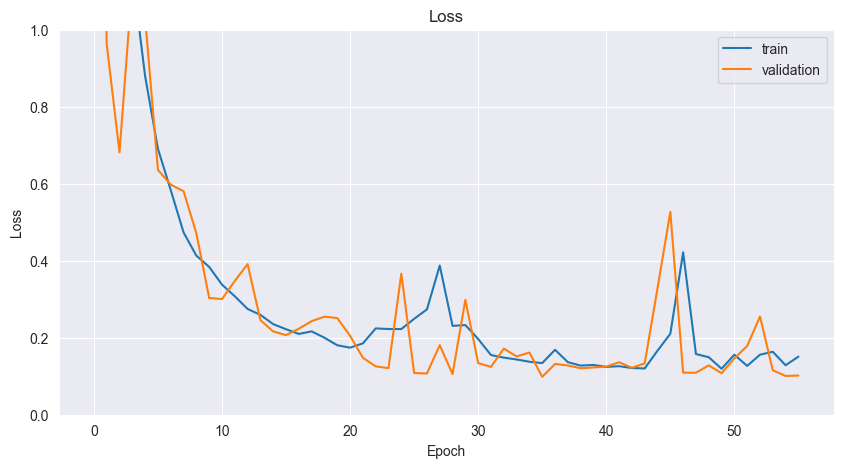

In [29]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='train')
plt.plot(history['valid_mse'],label='validation')
plt.ylim(0,1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()